In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/upgrad/SEM2/LogisticAssignment_LeadScoring/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/data/upgrad/SEM2/LogisticAssignment_LeadScoring


In [ ]:
# Imports

!pip install scikit-learn==0.24.1 category_encoders
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import DataFrame
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import time
import string
import re
from scipy import sparse
from joblib import Parallel

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import delayed
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# Function for printing different scores
def print_scores(model, X_test, y_test, mode='Test'):
  from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

  print(f"\n {mode} Set ROC AUC: ".format(mode), round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),2))
  print(f'\n Clasification Report on {mode} Set:\n'.format(mode), classification_report(y_test,model.predict(X_test)))
  print(f'\n Confussion Matrix:\n',confusion_matrix(y_test, model.predict(X_test)))

In [ ]:
# Defining encoder/transformer classes

class FeatureUnionPandas(FeatureUnion):

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
#         from joblib import Parallel
#         from sklearn.utils.fixes import delayed
       
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(pipeline._transform_one)(trans, X, None, weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
       
        # print("Processing FeatureUnion at:", round(time.time()/60)%1000, 'minutes')
       
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
   
    def fit_transform(self, X, y=None, **fit_params):
       
        results = self._parallel_func(X, y, fit_params, pipeline._fit_transform_one)

        if not results:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
       
        # print("Processing FeatureUnion at:", round(time.time()/60)%1000, 'minutes')
       
        Xs, transformers = zip(*results)
       
        self._update_transformer_list(transformers)
       
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs


class RareLabelCategoricalEncoder(BaseEstimator, TransformerMixin):
    """Rare label categorical encoder"""

    def __init__(self, variables=None, tol=0.001):
        self.tol = tol
        self.variables = variables

    def fit(self, X, y=None):

        if not isinstance(self.variables, list):
            self.variables = sorted([self.variables])
        else:
            self.variables = sorted(self.variables)
           
        # for compatibility with ColumnTransformer
        if self.variables == [None]:
            self.variables = X.columns
           
        # persist frequent labels in dictionary
        self.encoder_dict_ = {}

        X = X[self.variables].copy()
        for var in self.variables:
            X[var] = X[var].replace(r'^\s*$', np.nan, regex=True).fillna('ZZ').astype('str')
            # the encoder will learn the most frequent categories
            t = pd.Series(X[var].value_counts() / np.float(len(X)))
            # frequent labels:
            self.encoder_dict_[var] = list(t[t >= self.tol].index)

        return self

    def transform(self, X):
        # print("Processing RareLabelCategoricalEncoder at:", round(time.time()/60)%1000, 'minutes')
       
        X = X[self.variables].copy()
        for feature in self.variables:
            X[feature] = X[feature].replace(r'^\s*$', np.nan, regex=True).fillna('missing_value').astype('str')
            X[feature] = np.where(X[feature].isin(self.encoder_dict_[feature]), X[feature], 'Rare')
        return X


class StandardScalerPandas(BaseEstimator, TransformerMixin):
   
    def __init__(self):
        None
       
    def fit(self, X, y=None):
       
        self.columns = X.columns
        self.scaler = StandardScaler() #RobustScaler(unit_variance=True)
        self.scaler.fit(X)
       
        return self
   
    def transform(self, X):
       
        X = X.copy()
        index = X.index.values
        X = DataFrame(self.scaler.transform(X), index = index, columns = self.columns)
       
        return X

# Numeric class

class num_cleanup(BaseEstimator, TransformerMixin):
  def __init__(self, all_variables=None, replacing_char=None, min_variables=None, max_variables=None, 
               zerofill_variables=None, mean_variables=None, median_variables=None,
               capping_list = None, upper_cap_pct = 1, lower_cap_pct = 0):
    self.replacing_char = replacing_char
    self.min_variables = min_variables
    self.max_variables = max_variables
    self.zerofill_variables = zerofill_variables
    self.mean_variables = mean_variables
    self.median_variables = median_variables
    self.all_variables = all_variables
    self.capping_list = capping_list
    self.upper_cap_pct = upper_cap_pct
    self.lower_cap_pct = lower_cap_pct


  def fit(self, X, y=None):

    if self.all_variables == None:
      self.all_variables = X.select_dtypes(exclude = "O").columns

    X = X[self.all_variables].copy() 
    self.X_min = X.min()
    self.X_max = X.max()
    self.X_mean = X.mean()
    self.X_median = X.median()
    self.X_upper_quantile = X.quantile(self.upper_cap_pct)
    self.X_lower_quantile = X.quantile(self.lower_cap_pct)
    return self

  def transform(self, X):
    X = X[self.all_variables].copy() 
    if self.replacing_char is not None:
      X = X.replace({self.replacing_char: np.nan})
    if self.min_variables is not None:
      X[self.min_variables] = X[self.min_variables].fillna(self.X_min[self.min_variables])
    if self.max_variables is not None:
      X[self.max_variables] = X[self.max_variables].fillna(self.X_max[self.max_variables])
    if self.zerofill_variables is not None:
      X[self.zerofill_variables] = X[self.zerofill_variables].fillna(0)
    if self.mean_variables is not None:
      X[self.mean_variables] = X[self.mean_variables].fillna(self.X_mean[self.mean_variables])
    if self.median_variables is not None:
      X[self.median_variables] = X[self.median_variables].fillna(self.X_median[self.median_variables])
      X = X.fillna(self.X_median)
    if self.capping_list is not None:
      X[self.capping_list] = X[self.capping_list].clip(upper = self.X_upper_quantile, lower = self.X_lower_quantile, axis = 1)

    return X

In [ ]:
# Importing dataset
leads = pd.read_csv("Leads.csv")
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [ ]:
# Dropping the following columns because this is the data collected by the sales team after contacting potential leads.
leads = leads.drop(["Tags", "Lead Profile", "Lead Quality","Asymmetrique Activity Index", "Asymmetrique Profile Index", "Asymmetrique Activity Score", 
                "Asymmetrique Profile Score"],axis = 1)

# Setting "Lead Number as the index"
leads = leads.set_index("Lead Number")

# Replacing "Select" present in categorical variables with NaN
leads = leads.replace("Select",np.NaN)

# Converting Binary Variables (Yes/No) to (1/0)

# List of variables to map
varlist =  ['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper','Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses','Update me on Supply Chain Content','Get updates on DM Content','I agree to pay the amount through cheque','A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, 'No': 0})

# Applying the function to the varlist
leads[varlist] = leads[varlist].apply(binary_map)

# Adding "How did you hear about X Education" to 'cols_to_drop' list as it has 78.46% missing values as seen in EDA
cols_to_drop = ["How did you hear about X Education"]

In [ ]:
mean_cols = ["TotalVisits","Page Views Per Visit"]

All the remaining null values in categorical variables will be replaced with "missing_value"

###Investigating numeric variables


In [ ]:
leads.select_dtypes(include = "number").isnull().mean().sort_values(ascending = False)*100

TotalVisits                                 1.482684
Page Views Per Visit                        1.482684
A free copy of Mastering The Interview      0.000000
I agree to pay the amount through cheque    0.000000
Do Not Call                                 0.000000
Converted                                   0.000000
Total Time Spent on Website                 0.000000
Search                                      0.000000
Magazine                                    0.000000
Newspaper Article                           0.000000
X Education Forums                          0.000000
Newspaper                                   0.000000
Digital Advertisement                       0.000000
Through Recommendations                     0.000000
Receive More Updates About Our Courses      0.000000
Update me on Supply Chain Content           0.000000
Get updates on DM Content                   0.000000
Do Not Email                                0.000000
dtype: float64

All the null values in the numeric variables will be replaced with their respective column's mean value

In [ ]:
# Adding binary columns with low mean (less than 1%) to 'cols_to_drop' list as it shows that there is low variance in the data

cols_to_drop += ["Magazine", "Receive More Updates About Our Courses", "Update me on Supply Chain Content", "Get updates on DM Content",
                "I agree to pay the amount through cheque","X Education Forums", "Newspaper", "Do Not Call","Newspaper Article",
                "Digital Advertisement","Through Recommendations", "Search"]

# Adding 'Prospect ID' to cols_to_drop
cols_to_drop += ["Prospect ID"]

In [ ]:
# Dropping columns added to cols_to_drop 
leads1 = leads.drop(cols_to_drop, axis = 1)

leads1.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,City,A free copy of Mastering The Interview,Last Notable Activity
Lead Number,,,,,,,,,,,,,,,
660737,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,NaN,NaN,Unemployed,Better Career Prospects,NaN,0,Modified
660728,API,Organic Search,0,0,5.0,674,2.5,Email Opened,India,NaN,Unemployed,Better Career Prospects,NaN,0,Email Opened
660727,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,Mumbai,1,Email Opened
660719,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,Mumbai,0,Modified
660681,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,India,NaN,Unemployed,Better Career Prospects,Mumbai,0,Modified


In [ ]:
# Creating Pipelines

num_cols = ['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']

cat_cols = ['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Country', 'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity']


num_pipe = Pipeline([('num_clean_up', num_cleanup(all_variables= num_cols, mean_variables = ['TotalVisits','Page Views Per Visit'], 
                                                  capping_list = ["TotalVisits","Page Views Per Visit"], upper_cap_pct = 0.99)),
                     ('num_standard_scaler', StandardScalerPandas())
                     ])


cat_pipe = Pipeline([('rare_label_encoder', RareLabelCategoricalEncoder(variables=cat_cols)),
                     ('woe_encoder', ce.WOEEncoder(cols=cat_cols, return_df=True)),
                     ('cat_standard_scaler', StandardScalerPandas())
                    ])

combined_pipe = FeatureUnionPandas([('num', num_pipe),
                                    ('cat', cat_pipe)])

# Splitting into Train and Test Set

In [ ]:
X = leads1.drop("Converted", axis = 1)
y = leads1["Converted"]

# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100)

In [ ]:
X_train_processed = combined_pipe.fit_transform(X_train,y_train)
X_test_processed = combined_pipe.transform(X_test)

In [ ]:
# Processed X_train
X_train_processed.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,City,Country,Do Not Email,Last Activity,Last Notable Activity,Lead Origin,Lead Source,Specialization,What is your current occupation,What matters most to you in choosing a course
641410,-1.024895,-0.885371,-1.183466,0.673169,-1.085738,1.337659,0.291638,0.014987,-0.046947,-0.441132,-0.714835,0.969662,0.207682,0.647095
597687,0.203155,0.005716,-0.506234,-1.485511,0.336249,-0.469626,0.291638,0.014987,-0.046947,-0.172889,-0.361013,-1.183038,0.207682,0.647095
626825,0.510167,-0.691418,0.089527,0.673169,-1.085738,1.337659,0.291638,0.014987,-0.046947,-0.441132,-0.714835,-1.183038,0.207682,0.647095
587928,0.510167,1.365219,1.362519,0.673169,0.534035,-0.469626,0.291638,1.134974,1.637322,-0.172889,0.048147,-0.921230,0.207682,0.647095
622366,-1.024895,-0.885371,-1.183466,0.673169,-1.085738,1.337659,0.291638,0.014987,-0.867393,-0.441132,-0.714835,-1.183038,0.207682,0.647095


# Random Forest without Grid Search

In [ ]:
# Instantiating Random Forest 

rf = RandomForestClassifier()
rf.fit(X_train_processed, y_train)

RandomForestClassifier()

In [ ]:
print_scores(rf, X_train_processed, y_train, mode='Train')


 Train Set ROC AUC:  0.99

 Clasification Report on Train Set:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4002
           1       0.97      0.97      0.97      2466

    accuracy                           0.98      6468
   macro avg       0.98      0.98      0.98      6468
weighted avg       0.98      0.98      0.98      6468


 Confussion Matrix:
 [[3940   62]
 [  83 2383]]


In [ ]:
print_scores(rf, X_test_processed, y_test, mode='Test')


 Test Set ROC AUC:  0.9

 Clasification Report on Test Set:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1677
           1       0.80      0.73      0.77      1095

    accuracy                           0.82      2772
   macro avg       0.82      0.81      0.81      2772
weighted avg       0.82      0.82      0.82      2772


 Confussion Matrix:
 [[1480  197]
 [ 291  804]]


The clasification report of Random Forest model without Grid Search is shown above. Let's check out the results for Random Forest model with Grid Search next.

# Random Forest with Grid Search

In [ ]:
# GridSearchCV

hyper_params_cv_rf = {
                'max_features': [0.05, 0.10, 0.25],
                'min_samples_leaf': [3, 7, 11, 15],
                'n_estimators': [100, 200, 500]
               }


model_cv_rf = GridSearchCV(estimator=RandomForestClassifier(), 
             param_grid=hyper_params_cv_rf,
             verbose=1,
             cv=5,
             scoring = "recall",
             n_jobs=-1,
             return_train_score=True)

model_cv_rf.fit(X_train_processed, y_train)

print(model_cv_rf.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomForestClassifier(max_features=0.25, min_samples_leaf=7)


In [ ]:
print('CV Recall Score: ', round(model_cv_rf.best_score_,2))

print_scores(model_cv_rf, X_train_processed, y_train, mode='Train')

CV Recall Score:  0.76

 Train Set ROC AUC:  0.94

 Clasification Report on Train Set:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      4002
           1       0.84      0.79      0.81      2466

    accuracy                           0.86      6468
   macro avg       0.86      0.85      0.85      6468
weighted avg       0.86      0.86      0.86      6468


 Confussion Matrix:
 [[3633  369]
 [ 529 1937]]


In [ ]:
print_scores(model_cv_rf, X_test_processed, y_test, mode='Test')


 Test Set ROC AUC:  0.91

 Clasification Report on Test Set:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1677
           1       0.82      0.74      0.78      1095

    accuracy                           0.84      2772
   macro avg       0.83      0.82      0.82      2772
weighted avg       0.83      0.84      0.83      2772


 Confussion Matrix:
 [[1500  177]
 [ 280  815]]


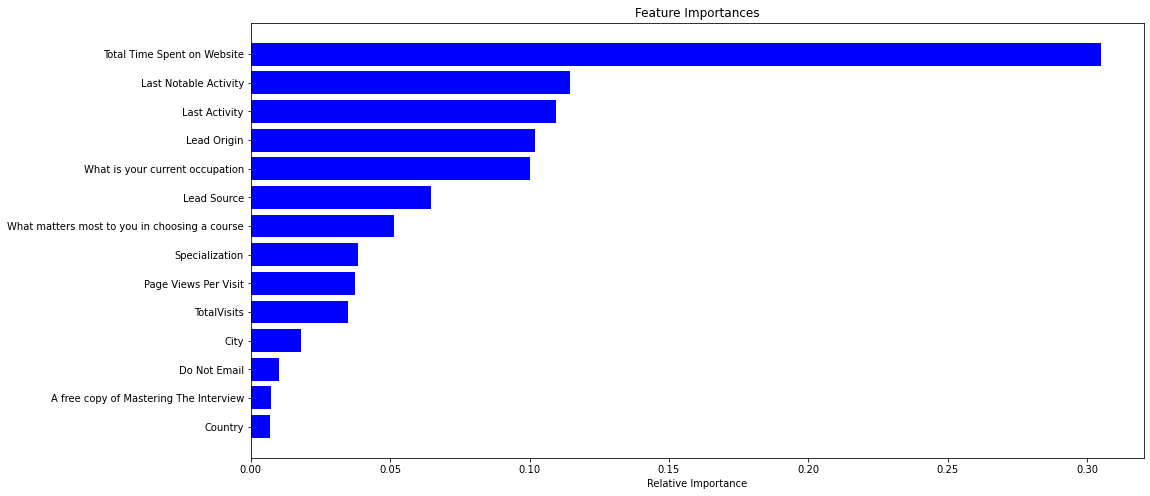

In [ ]:
# Feature Importances

features = X_train_processed.columns
importances = model_cv_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

"Total Time Spent on Website" is the most important feature.

# Logistic Model

In [ ]:
# Checking highly correlated variables (above 0.8) 

corr = abs(X_train_processed.corr()).stack().reset_index().sort_values(0, ascending = False)
corr.columns = ["col1","col2","correlation"]
corr[(corr.col1 != corr.col2) & (corr.correlation > 0.8)]

,col1,col2,correlation
136,Lead Origin,Lead Source,0.938137
149,Lead Source,Lead Origin,0.938137


In [ ]:
# Dropping "Lead Origin" as it is highly correlated with "Lead Source"

X_train_processed = X_train_processed.drop(["Lead Origin"], axis = 1)
X_test_processed = X_test_processed.drop(["Lead Origin"], axis = 1)

In [ ]:
# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train_processed.columns
vif['VIF'] = [variance_inflation_factor(X_train_processed.values, i) for i in range(X_train_processed.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,What is your current occupation,2.43
2,Page Views Per Visit,2.30
7,Last Activity,2.29
12,What matters most to you in choosing a course,2.29
10,Specialization,2.15
4,City,2.10
8,Last Notable Activity,2.06
0,TotalVisits,2.01
5,Country,1.57
3,A free copy of Mastering The Interview,1.39


The highest VIF is 2.43 for "What is your current occupation". Typically it is better to have VIF below 10

In [ ]:
# Logistic regression model

logm = sm.GLM(y_train,(sm.add_constant(X_train_processed)), family = sm.families.Binomial()).fit()
logm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2607.4
Date:                Sun, 07 Mar 2021   Deviance:                       5214.8
Time:                        19:40:01   Pearson chi2:                 7.52e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.6790      0.039    -17.634      0.000      -0.754      -0.604
TotalVisits                                       0.2768      0.047      5.899      0.000       0.185       0.369
Total Time Spent on Website                       1.0355      0.040     25.904      0.000       0.957       1.114
Page Views Per Visit                             -0.3952      0.053     -7.482      0.000      -0.499      -0.292
A free copy of Mastering The Interview            0.1558      0.040      3.934      0.000       0.078       0.233
City                                              0.0041      0.050      0.082      0.934      -0.093       0.102
Country                                           0.6231      0.060     10.416      0.000       0.506       0.740
Do Not Email                                      0.2440      0.045      5.477      0.000       0.157       0.331
Last Activity                                     0.4707      0.058      8.105      0.000       0.357       0.584
Last Notable Activity                             0.4721      0.050      9.452      0.000       0.374       0.570
Lead Source                                       0.6048      0.048     12.691      0.000       0.511       0.698
Specialization                                    0.1881      0.051      3.716      0.000       0.089       0.287
What is your current occupation                   0.9485      0.072     13.139      0.000       0.807       1.090
What matters most to you in choosing a course    -0.1181      0.062     -1.905      0.057      -0.240       0.003
=================================================================================================================
"""

In [ ]:
# Dropping variable with high p-values

X_train_processed = X_train_processed.drop(["City"],axis = 1)
X_test_processed= X_test_processed.drop(["City"],axis = 1)

In [ ]:
# Final Logistic Regression Model

logm = sm.GLM(y_train,(sm.add_constant(X_train_processed)), family = sm.families.Binomial()).fit()
logm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2607.4
Date:                Sun, 07 Mar 2021   Deviance:                       5214.8
Time:                        19:40:01   Pearson chi2:                 7.53e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.6788      0.038    -17.652      0.000      -0.754      -0.603
TotalVisits                                       0.2769      0.047      5.906      0.000       0.185       0.369
Total Time Spent on Website                       1.0356      0.040     25.913      0.000       0.957       1.114
Page Views Per Visit                             -0.3950      0.053     -7.490      0.000      -0.498      -0.292
A free copy of Mastering The Interview            0.1553      0.039      3.964      0.000       0.079       0.232
Country                                           0.6227      0.060     10.445      0.000       0.506       0.740
Do Not Email                                      0.2439      0.045      5.477      0.000       0.157       0.331
Last Activity                                     0.4708      0.058      8.111      0.000       0.357       0.585
Last Notable Activity                             0.4720      0.050      9.454      0.000       0.374       0.570
Lead Source                                       0.6049      0.048     12.698      0.000       0.512       0.698
Specialization                                    0.1904      0.042      4.513      0.000       0.108       0.273
What is your current occupation                   0.9485      0.072     13.138      0.000       0.807       1.090
What matters most to you in choosing a course    -0.1180      0.062     -1.903      0.057      -0.240       0.004
=================================================================================================================
"""

In [ ]:
print("ROC AUC of the Train Data:",round(roc_auc_score(y_train, logm.predict(sm.add_constant(X_train_processed)).values.reshape(-1)),3))

ROC AUC of the Train Data: 0.892


In [ ]:
print("ROC AUC of the Train Data:",round(roc_auc_score(y_test, logm.predict(sm.add_constant(X_test_processed)).values.reshape(-1)),3))

ROC AUC of the Train Data: 0.895


###Plotting the ROC Curve


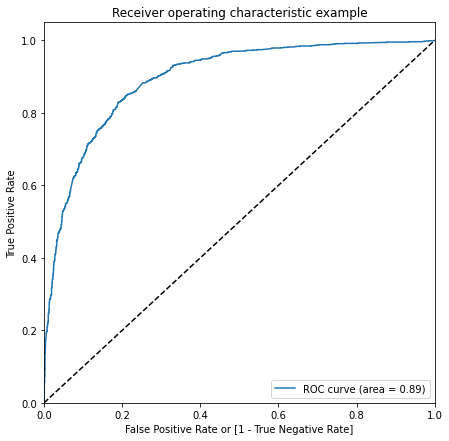

In [ ]:
def draw_roc( actual, probs ):
    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(7, 7))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None


draw_roc(y_test, logm.predict(sm.add_constant(X_test_processed)).values.reshape(-1))

### Finding Optimal Cutoff Point



In [ ]:
# Creating a new data frame y_test_pred to find optimal cut-off

y_test_pred = pd.DataFrame(y_test.values, columns=['actuals'], index=y_test.index)
y_test_pred['pred_prob'] = logm.predict(sm.add_constant(X_test_processed)).values.reshape(-1)

# Let's create columns with different probability cutoffs 
numbers = [float(x)/20 for x in range(20)]
for i in numbers:
    y_test_pred[i]= y_test_pred.pred_prob.map(lambda x: 1 if x > i else 0)
y_test_pred.head()

,actuals,pred_prob,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
Lead Number,,,,,,,,,,,,,,,,,,,,,,
619003,1,0.355466,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
636884,1,0.936233,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
590281,1,0.756687,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0
579892,0,0.101420,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
617929,1,0.855000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in numbers:
    cm1 = metrics.confusion_matrix(y_test_pred.actuals, y_test_pred[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

cutoff_df

,prob,accuracy,sensi,speci
0.00,0.00,0.395022,1.000000,0.000000
0.05,0.05,0.528139,0.991781,0.225403
0.10,0.10,0.638528,0.978082,0.416816
0.15,0.15,0.725108,0.950685,0.577818
0.20,0.20,0.772367,0.931507,0.668456
0.25,0.25,0.790404,0.894977,0.722123
0.30,0.30,0.810606,0.852055,0.783542
0.35,0.35,0.815296,0.812785,0.816935
0.40,0.40,0.815657,0.774429,0.842576
0.45,0.45,0.815657,0.729680,0.871795


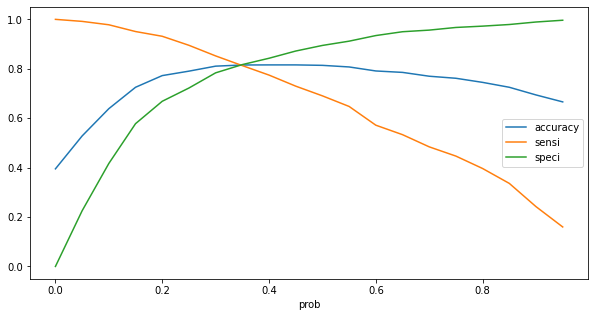

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot(kind = "line", x='prob', y=['accuracy','sensi','speci'], figsize=(10,5))
plt.show()

In [ ]:
# From the above graph, we see that the optimal cut-off is at 0.35
y_test_pred['optimum_predictions'] = y_test_pred[0.35]

y_test_pred = y_test_pred[['actuals', 'optimum_predictions', 'pred_prob']]
y_test_pred.head()

,actuals,optimum_predictions,pred_prob
Lead Number,,,
619003,1,1,0.355466
636884,1,1,0.936233
590281,1,1,0.756687
579892,0,0,0.101420
617929,1,1,0.855000


In [ ]:
print(classification_report(y_test_pred.actuals, y_test_pred.optimum_predictions))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1677
           1       0.74      0.81      0.78      1095

    accuracy                           0.82      2772
   macro avg       0.81      0.81      0.81      2772
weighted avg       0.82      0.82      0.82      2772



#### We see that the accuracy of the model on the test set is 82%

In [ ]:
# Confusion matrix
confusion_mat = metrics.confusion_matrix(y_test_pred.actuals, y_test_pred.optimum_predictions )
confusion_mat

array([[1370,  307],
       [ 205,  890]])

In [ ]:
TP = confusion_mat[1,1] # true positive 
TN = confusion_mat[0,0] # true negatives
FP = confusion_mat[0,1] # false positives
FN = confusion_mat[1,0] # false negatives

In [ ]:
# Sensitivity
round(TP / (TP+FN), 2)

0.81

We see that the sensitivity of the model on the test set is 81%

In [ ]:
# Specificity
round(TN / float(TN+FP), 2)

0.82

We see that the specificity of the model on the test set is 82%

Accuracy: 82%

Sensitivity: 81%

Specificity: 82%

F1 score: 78%

Conversion Rate (Precision): 74%

#Fin!